In [1]:
import matplotlib.pyplot as plt
import time
import os
import pickle

import torch
import numpy as np

from sbi import analysis
from sbi import utils as utils
from sbi.utils.user_input_checks import process_prior

from simulations_model1 import simulator_sbi_entropy
from parsing_functions import save_pickle_data, load_input_data, extract_specs

from tqdm.notebook import tqdm  # Use tqdm if you're not in a notebook environment

In [2]:
def compute_entropies(n_samples, theta_true, simulator_to_sbi_entropy, posterior):
    # Declare the lists inside the function
    x_obs = []
    S = []
    samples = []
    sample_pars = []
    S_true = []
    
    # Use tqdm to show progress
    for i in tqdm(range(n_samples), desc="Computing entropies"):
        x_obs1, S1 = simulator_to_sbi_entropy(theta_true[i])
        x_obs.append(x_obs1)
        S.append(S1)
        samples.append(posterior.sample((50000,), x=x_obs[i], show_progress_bars=False))
        sample_pars.append(torch.mean(samples[i], dim=0))
        x_obs_true1, S_true1 = simulator_to_sbi_entropy(sample_pars[i])
        S_true.append(S_true1)
    
    return S, S_true

In [3]:
low2_tensor = torch.tensor([0,0.1,0])
high2_tensor = torch.tensor([4,4,4])

def simulator_to_sbi_entropy(pars):
    return simulator_sbi_entropy(np.array(pars), dt, int(oversampling), int(prerun),int(Npts), prefix)

prior_sbi = utils.BoxUniform(low=low2_tensor, high=high2_tensor)

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_sbi)

In [4]:
posterior_dir = 'saved_posteriors'
posterior_name = 'posterior_None_5000sim_5e+04np_1e-02dt_10os_1e+02pre.pickle'
specs = extract_specs(posterior_name)

specs_dict = extract_specs(posterior_name)

# Unpack the specifications from the dictionary
num_simulations = specs_dict['num_simulations']
Npts = specs_dict['Npts']
dt = specs_dict['dt']
oversampling = specs_dict['oversampling']
prerun = specs_dict['prerun']
prefix = specs_dict['prefix']

posterior_path = dataset_path = os.path.join(posterior_dir, posterior_name)

# Saving string for future saving
specs = f'{prefix}_{num_simulations:.0f}sim_{Npts:.0e}np_{dt:.0e}dt_{oversampling}os_{prerun:.0e}pre'
print(specs)

with open(posterior_path, "rb") as handle:
    posterior = pickle.load(handle)

None_5000sim_5e+04np_1e-02dt_10os_1e+02pre


In [5]:
theta_true = prior.sample((1,))
print(theta_true)
# generate our observation
x_obs, S = simulator_to_sbi_entropy(theta_true[0])
samples = posterior.sample((500000,), x=x_obs)

tensor([[2.4858, 1.8607, 1.8486]])


Drawing 500000 posterior samples:   0%|          | 0/500000 [00:00<?, ?it/s]

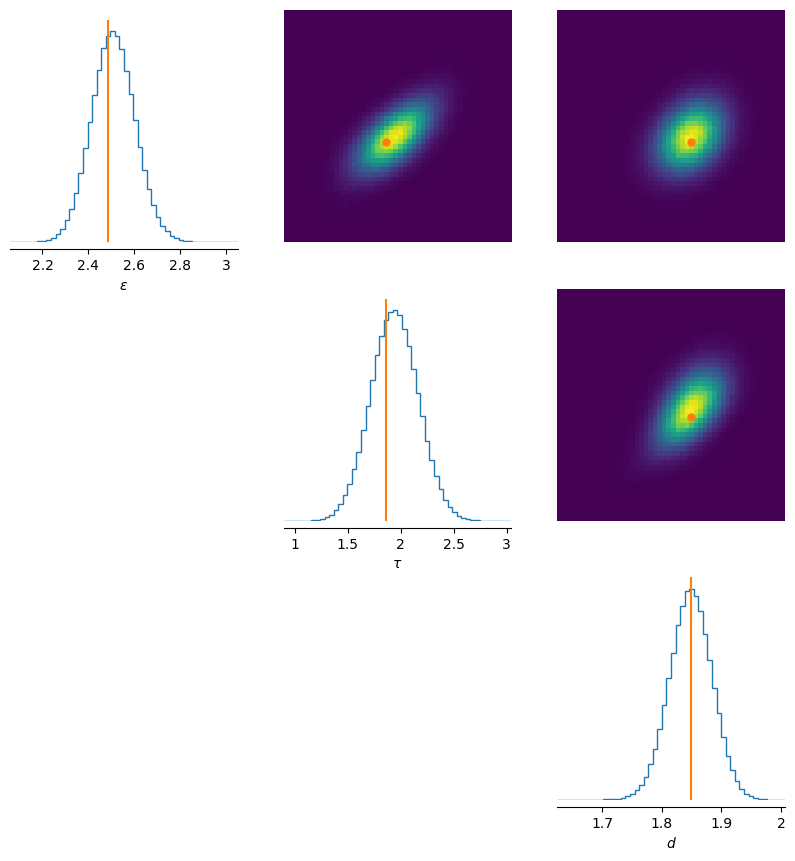

In [6]:
fig,ax = analysis.pairplot(samples, points=theta_true, figsize=(10, 10),labels=[r"$\epsilon$", r"$\tau$", r"$d$"])

fig_save_dir = 'saved_figures'
fig_name = 'analysisSNPE_' + str(specs)


# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir): os.makedirs(fig_save_dir)
fig_path = os.path.join(fig_save_dir, fig_name)

fig.savefig(fig_path, dpi = 300)

In [7]:
n_samples = 10
theta_true = prior.sample((n_samples,))

S,S_true = compute_entropies(n_samples, theta_true, simulator_to_sbi_entropy, posterior)

# Using list comprehension to filter elements < 0 and then count them
count = len([x for x in S if x < 0])

print("Number of elements in S that are less than 0:", count)

Computing entropies:   0%|          | 0/10 [00:00<?, ?it/s]

Number of elements in S that are less than 0: 0
CPU times: user 1min 16s, sys: 23.5 s, total: 1min 40s
Wall time: 18.9 s


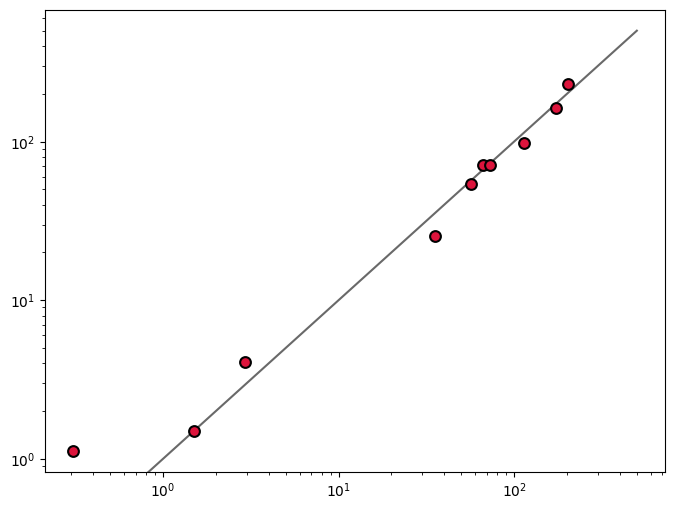

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
s=60
ax.scatter(np.array(S),np.array(S_true),s=s,edgecolor='black',lw=1.5,facecolor='crimson',zorder=2)
xx = np.linspace(0,500,100)
ax.plot(xx,xx,zorder=0,color='dimgray')
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

fig_save_dir = 'saved_plots'
fig_name = 'entropySNPE_' + str(specs)


# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir): os.makedirs(fig_save_dir)
fig_path = os.path.join(fig_save_dir, fig_name)

fig.savefig(fig_path, dpi = 300)